#### Imports

In [8]:
import tensorflow as tf
import cv2
import os
import glob
import keras
from keras_video import VideoFrameGenerator, SlidingFrameGenerator
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
import matplotlib.pyplot as plt

#### Loading DIR

In [11]:

# use sub directories names as classes
classes = [i.split(os.path.sep)[1] for i in glob.glob('../Data/Videos/wlasl-complete/sample_classes/*')]
classes.sort()

# some global params
# Set size to 224, 224
SIZE = (112, 112)
CHANNELS = 3
NBFRAME = 5
BS = 32

# pattern to get videos and classes
glob_pattern='../Data/Videos/wlasl-complete/sample_classes/{classname}/*.mp4'

# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)


# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split=.3, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=False)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class a, validation count: 2, train count: 6
class a lot, validation count: 2, train count: 6
class abdomen, validation count: 2, train count: 6
class able, validation count: 2, train count: 6
class about, validation count: 4, train count: 11
class above, validation count: 2, train count: 7
class accent, validation count: 2, train count: 5
class accept, validation count: 3, train count: 9
class accident, validation count: 5, train count: 14
class accomplish, validation count: 2, train count: 7
Total data: 10 classes for 77 files for train


In [12]:
valid = train.get_validation_generator()

Total data: 10 classes for 26 files for validation


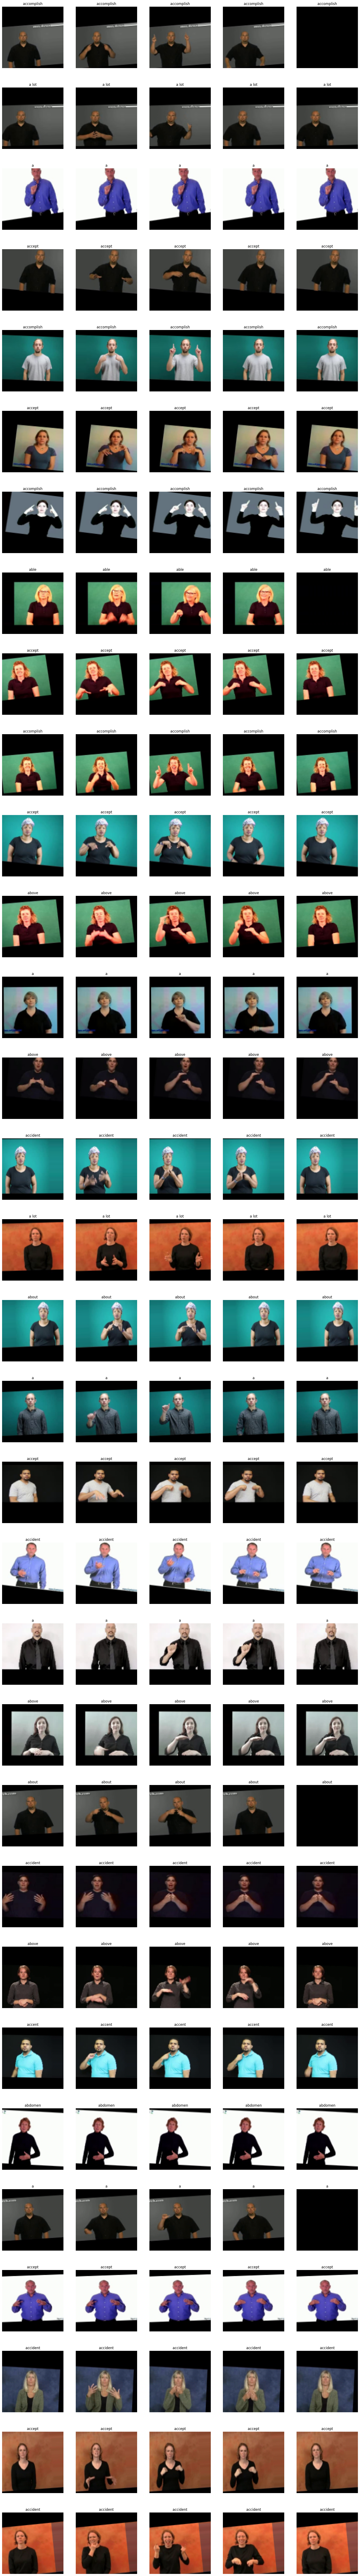

In [13]:
import keras_video.utils
keras_video.utils.show_sample(train)

In [5]:

def build_convnet(shape=(112, 112, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [6]:
def build_mobilenet(shape=(224, 224, 3), nbout=1999):
    model = keras.applications.mobilenet.MobileNet(
        include_top=False,
        input_shape=shape,
        weights='imagenet')
    # Keep 9 layers to train
    trainable = 9
    for layer in model.layers[:-trainable]:
        layer.trainable = False
    for layer in model.layers[-trainable:]:
        layer.trainable = True
    output = GlobalMaxPool2D()
    return keras.Sequential([model, output])

In [7]:
def build_resnet(shape=(112, 112, 3), nbout=1999):
    model = tf.keras.applications.resnet50.ResNet50(
        include_top=True,
        weights=None,
        input_tensor=None,
        input_shape=shape,
        pooling=None,
        classes=nbout,)
    return model

In [8]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
def action_model(shape=(5, 112, 112, 3), nbout=1999):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_resnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(20384, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(10192, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(5096, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [9]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 224, 224, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.SGD()
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)
model.summary()


ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[20384,10192] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [ ]:
model = tf.keras.models.load_model('ASL_mobile_40.keras')

In [ ]:
EPOCHS=110
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        '../Data/Videos/wlasl-complete/chkpRes/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]
history = model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks,
)

In [ ]:
model.save('ASL_mobile_80.keras')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy',color="orange")
plt.plot(epochs_range, val_acc, label='Validation Accuracy',color="blue")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

